In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from numba import njit, prange

In [211]:
@njit
def GLP(x, n, alpha):  # Generalized Laguerre polynomials
    L0 = np.ones_like(x)
    L1 = 1.0 + alpha - x

    if n == 0:
        Ln = L0
    if n == 1:
        Ln = L1

    for i in range(2, n + 1):
        k = i - 1
        Ln = (((2 * k + 1 + alpha - x)) * L1 - (k + alpha) * L0) / (k + 1)
        L0, L1 = L1, Ln

    return Ln


@njit
def Skl(r, k, l, q):  # Sturmian
    # np.sqrt((factorial(k) / (2 * factorial(2 * l + 1 + k)))) before usage of log gamma function
    return (
        np.sqrt(1 / 2)
        * np.exp(
            (1 / 2) * (np.math.lgamma(k + 1) - np.math.lgamma(2 * l + 2 + k))
        )  # Using log gamma to avoid overflow
        * np.exp(-q * r)
        * ((2 * q * r) ** (l + 1))
        * GLP(2 * q * r, k, 2 * l + 1)
    )


@njit
def V(r):
    return -1 / r


@njit
def Z(r, z, a1, a2, a3, a4):
    return 1 + (z - 1) * np.exp(-a1 * r) - r * (a3 + a4 * r) * np.exp(-a2 * r)


@njit
def V1(r, alpha_c, rc, a1, a2, a3, a4, z):
    return -(Z(r, z, a1, a2, a3, a4)) / r - (alpha_c / (2 * r**4)) * (1 - (np.exp(-((r / rc) ** 6))))

In [103]:
atoms = {
    "Li": {
        "z": 3,
        "alpha_c": 0.1923,
        "rc": 0.61340824,
        "a1": 2.47718079,
        "a2": 1.84150932,
        "a3": -0.02169712,
        "a4": -0.11988362,
    },
    "Rb":
    {
        "z": 37,
        "alpha_c": 9.0760,
        "rc": 1.66242117,
        "a1": 3.69628474,
        "a2": 1.64915255,
        "a3": -9.86069196,
        "a4": 0.19579987,
    },
    "Cs":
    {
        "z": 55,
        "alpha_c": 15.6440,
        "rc": 1.92046930,
        "a1": 3.49546309,
        "a2": 1.47533800,
        "a3": -9.72143084,
        "a4": 0.02629242,
    },
}

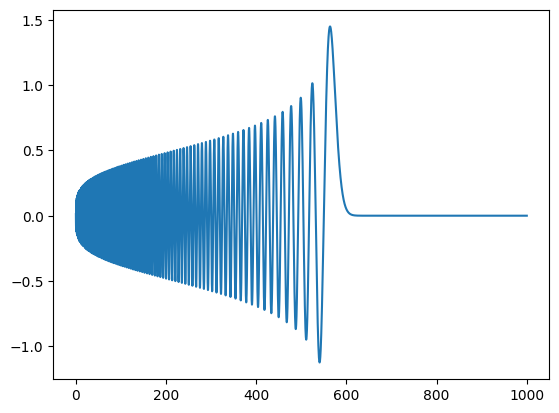

In [220]:
x = np.linspace(0.001, 1000, 10000)
plt.plot(x, Skl(x, 200, 0, 0.7))

In [5]:
def HB(N, l, q, r_min, r_max, Nr, dtype):
    print(f"H,B calculation for N={N}")

    x = np.linspace(np.sqrt(r_min), np.sqrt(r_max), Nr + 1, dtype=dtype)
    B = np.zeros((N, N), dtype=dtype)
    H = np.zeros((N, N), dtype=dtype)
    S = np.zeros((N, Nr), dtype=dtype)
    S_diff = np.zeros((N, Nr), dtype=dtype)

    r1 = x**2
    r = r1[0:-1]
    dr = r1[1:] - r

    V_r = V(r)

    return HBC(N=N, l=l, q=q, r=r, r1=r1, S=S, S_diff=S_diff, dr=dr, V_r=V_r, H=H, B=B)

@njit(parallel=True, fastmath=True)
def HBC(N, l, q, r, r1, S, S_diff, dr, V_r, H, B):

    for n in prange(N):
        Sn = Skl(r1, n, l, q)
        S[n] = Sn[0:-1]
        S_diff[n] = (Sn[1:]-Sn[:-1])/dr
        
    for n in prange(N):
        for k in prange(n, N):
            
            B[n, k] = (S[n] * S[k] * dr).sum()
            
                
            H[n, k] = (
                (
                    (1/2)*S_diff[n]*S_diff[k] + 
                    S[n]*S[k]*(V_r + (l)*(l+1)/(2*r**2))
                )
                * (dr)
            ).sum()
            
            
            if n != k:
                B[k, n] = B[n, k]
                H[k, n] = H[n, k]
            
    return H, B

In [271]:
N = 200
l = 0
q = 0.7

r_min = 10**-13
r_max = 700
Nr = 4*10**5

V = lambda r: V1(r, **atoms["Li"])

In [272]:
H, B = HB(N, l, q, r_min, r_max, Nr, np.float64)

H,B calculation for N=200


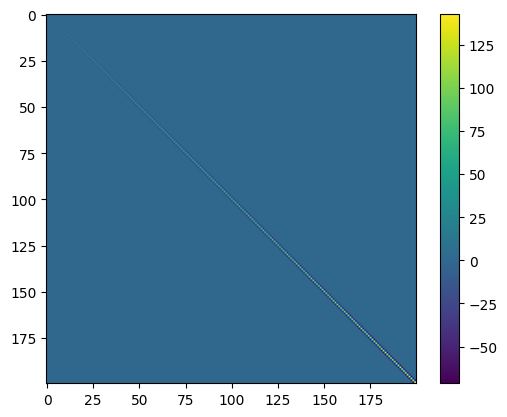

In [273]:
plt.imshow(B)
plt.colorbar()

In [274]:
eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
eigenvalues.sort()

In [275]:
eigenvalues

array([-1.87916395e+00, -1.98156235e-01, -7.41842753e-02, -3.86188042e-02,
       -2.36392491e-02, -1.59468339e-02, -1.14793633e-02, -8.65677226e-03,
       -6.76042872e-03, -5.42527767e-03, -4.44988616e-03, -3.71571591e-03,
       -3.14931584e-03, -2.70320444e-03, -2.34554968e-03, -2.05264286e-03,
       -1.78960459e-03, -1.50096833e-03, -1.16066471e-03, -7.69918404e-04,
       -3.32751747e-04,  1.48125564e-04,  6.70967885e-04,  1.23461927e-03,
        1.83830708e-03,  2.48151965e-03,  3.16393820e-03,  3.88538702e-03,
        4.64580767e-03,  5.44523301e-03,  6.28377775e-03,  7.16162179e-03,
        8.07900848e-03,  9.03623196e-03,  1.00336398e-02,  1.10716218e-02,
        1.21506157e-02,  1.32710966e-02,  1.44335845e-02,  1.56386338e-02,
        1.68868425e-02,  1.81788416e-02,  1.95153055e-02,  2.08969411e-02,
        2.23244993e-02,  2.37987636e-02,  2.53205631e-02,  2.68907599e-02,
        2.85102640e-02,  3.01800191e-02,  3.19010196e-02,  3.36742951e-02,
        3.55009286e-02,  

In [243]:
print("Eigenvalues:")
for i in range(0, 4):
    print(f" {eigenvalues[i]:.12g}", end="")

Eigenvalues:
 -1.87998135817 -0.198198070131 -0.0741950387233 -0.0386231581026

In [276]:
def f(n, d):
    return 1/((n - d)**2 + 10**-16)

n_fit_min = 30
n_fit_max = 50

val, _ = sp.optimize.curve_fit(f, np.arange(n_fit_min+1, n_fit_max+1), eigenvalues[n_fit_min:n_fit_max])
constant, = val

In [285]:
constant,

(23.274769319470245,)

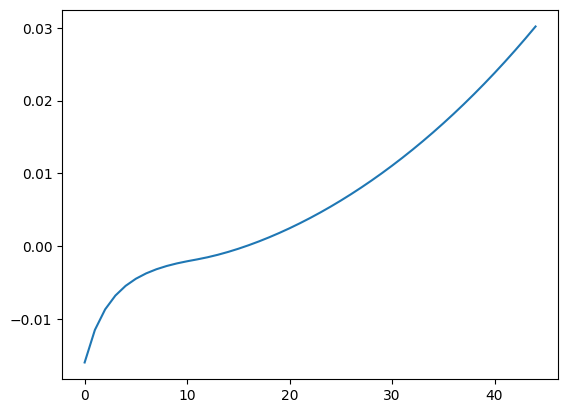

In [284]:
plt.plot(eigenvalues[5:n_fit_max])

H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30
H,B calculation for N=30


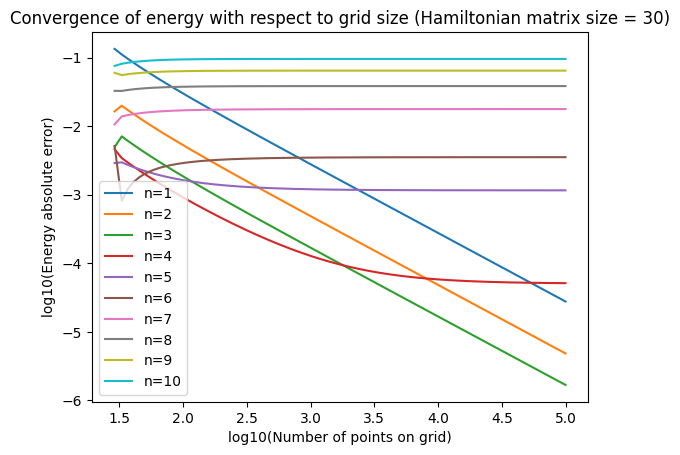

In [43]:
N = 30
l = 0
q = 0.7

r_min = 10**-13
r_max = 50

energies = []
Nr_list = np.linspace(np.sqrt(1.0), np.sqrt(100000), 1000)
Nr_list = np.round(Nr_list**2).astype(int)

# Nr_list = [100, 120, 140, 160, 180, 200, 300, 400, 600, 1000, 2000, 5000, 9000, 10000, 11000, 30000, 100000, 500000, 1000000,]
for Nr in Nr_list:
    H, B = HB(N, l, q, r_min, r_max, Nr, np.float64)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies.append(np.array(eigenvalues))
    except Exception as e:
        energies.append(np.array([np.nan]*N))
energies = np.array(energies)

energies = energies.T

for i in range(10):
    plt.plot(np.log10(Nr_list), np.log10(np.abs(energies[i] - (-1/2 *(1/(i + 1)**2)))), label=f"n={i+1}")

plt.title(f"Convergence of energy with respect to grid size (Hamiltonian matrix size = {N})")
plt.xlabel("log10(Number of points on grid)")
plt.ylabel("log10(Energy absolute error)")
plt.legend()

H,B calculation for N=5
H,B calculation for N=6
H,B calculation for N=7
H,B calculation for N=8
H,B calculation for N=9
H,B calculation for N=11
H,B calculation for N=12
H,B calculation for N=13
H,B calculation for N=14
H,B calculation for N=15
H,B calculation for N=17
H,B calculation for N=18
H,B calculation for N=19
H,B calculation for N=20
H,B calculation for N=21
H,B calculation for N=23
H,B calculation for N=24
H,B calculation for N=25
H,B calculation for N=26
H,B calculation for N=27
H,B calculation for N=29
H,B calculation for N=30
H,B calculation for N=31
H,B calculation for N=32
H,B calculation for N=33
H,B calculation for N=35
H,B calculation for N=36
H,B calculation for N=37
H,B calculation for N=38
H,B calculation for N=40


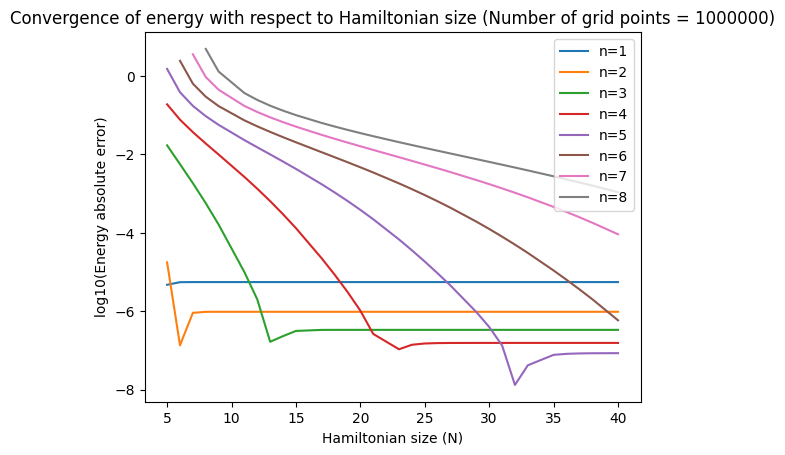

In [170]:
N = 30
l = 0
q = 0.7

r_min = 10**-13
r_max = 200
Nr = 10**6



N_list = np.linspace(5, 40, 30).astype(int)
energies = np.zeros((N_list.max(),N_list.shape[0]))
energies.fill(np.nan)

for i, N in enumerate(N_list):
    H, B = HB(N, l, q, r_min, r_max, Nr, np.float64)
    try:
        eigenvalues, eigenvectors = sp.linalg.eigh(H, B)
        eigenvalues.sort()
        energies[:eigenvalues.shape[0], i] = eigenvalues
    except Exception as e:
        pass

energies = np.array(energies)

for i in range(8):
    # np.abs(energies[i] - (-1/2 *(1/(i + 1)**2))) / (1/2 *(1/(i + 1)**2))
    plt.plot(N_list, np.log10(np.abs(energies[i] - (-1/2 *(1/(i + 1)**2)))), label=f"n={i+1}")

# plt.ylim(0.0, 0.6)
plt.title(f"Convergence of energy with respect to Hamiltonian size (Number of grid points = {Nr})")
plt.xlabel("Hamiltonian size (N)")
plt.ylabel("log10(Energy absolute error)")
plt.legend()